In [1]:
import pandas as pd
#from ast import literal_eval
#import texthero as hero
#import nltk
#from nltk import bigrams
#from nltk.tokenize import RegexpTokenizer
#from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import itertools
import networkx as nx
from networkx.readwrite import json_graph
import pylab
import matplotlib.pyplot as plt
from pyvis.network import Network
import plotly.express as px
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
import ipywidgets as widgets
from IPython.display import display, FileLink, FileLinks
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [2]:
######## charts functions #################
##########################################

def get_crosstab(df, col1, col2):
    c = pd.crosstab(df[col1], df[col2]).reset_index()
    return c

def get_crosstab_percent(df, col1, col2):
    c = (pd.crosstab(df[col1], df[col2], normalize='index')*100).round(1).reset_index()
    return c   

def value_counts_dataframe(df,key,sort_key):
    d = pd.DataFrame({'Group':df[key].value_counts().index, 'Count':df[key].value_counts().values}).sort_values(by=sort_key, ascending=False)
    d["Group"] = d["Group"].astype(str)
    return d

########## network functions ################
#############################################

def viz_network(bigram_df):
    d = bigram_df.set_index('bigram')[:100].T.to_dict('records')
    net = Network(notebook=True,
      cdn_resources="remote",
      bgcolor="#222222",
      font_color="white",
      height="750px",
      width="100%",
      select_menu=True,
      filter_menu=True,
      )
    net.repulsion(node_distance=250, spring_length=200)
    net.show_buttons(filter_=["nodes","edges"])
    for k, v in d[0].items():
        net.add_node(k[0], label=k[0],size=25)
        net.add_node(k[1], label=k[1])
        net.add_edge(k[0], k[1])
    return net

########## Data #############################
#############################################

df = pd.read_csv("data/2_results/nlp_corpus.csv", sep=",", encoding="utf-8")
for column_name in df.columns:
    df[column_name] = df[column_name].astype('string')
df_title_unigrams = pd.read_csv("data/2_results/Title_unigrams.csv", sep=",", encoding="utf-8")
df_title_bigrams = pd.read_csv("data/2_results/Title_bigrams.csv", sep=",", encoding="utf-8")
df_abstract_unigrams = pd.read_csv("data/2_results/Abstract_unigrams.csv", sep=",", encoding="utf-8")
df_abstract_bigrams = pd.read_csv("data/2_results/Abstract_bigrams.csv", sep=",", encoding="utf-8")

# Objet

La demande porte sur la constitution d'un corpus d'articles contenant le terme "radiocology" dans le titre et sur l'analyse de ce corpus :

- analyse quantitative : nombre de publications par date, par revue et par type de publication
- analyse lexicométrique
  - Co-occurrences dans le champ titre
  - Co-occurences avec le terme radioecology dans le titre
  
Cette note présente seulement des réponses de type programmatiques, deux outils complémentaires de etxt mining en ligne sont aussi présentés à la fin.

Les données brutes sont également téléchargeables depuis cette page (fin de page)

# Constitution du corpus

## Source Scopus

1. Extraction (par l'interface web Scopus)

- Périmètre : `radio*ecolog*` dans tous les champs et sur la période `1964-2023`
- Requête : `ALL ( radio*ecolog* )`
- Nombre de résultats : `13 631 publications`
- Nombre de résultats après traitement : `11 129 publications`

2. Export des champs : 'Authors', 'Title', 'Year', 'Source title', 'DOI',
       'Document Type', 'Source', 'Publisher', 'Abstract'

## Source Istex

::: {.callout-note}
##### Rappel Istex

Istex est un réservoir national d’archives scientifiques normalisées constitué par 4 opérateurs institutionnels (CNRS, Abes, consortium Couperin et Université de Loraine) suite à l'acquisition centralisée et pérenne de collections retrospectives de littérature scientifique auprès de multiples éditeurs. La plateforme Istex héberge et donne accès à 27 milions de publications, assorties de métadonnées enrichies.

- Plateforme Istex : [https://www.istex.fr/](https://www.istex.fr/)
- Documentation : [https://doc.istex.fr/](https://doc.istex.fr/)
:::

1. Extraction (par l'API Istex)

- Périmètre : `radio*ecolog* dans tous les champs, filtre sur les docs de type article` (beaucoup de bruit sinon)
- Requête : `https://api.istex.fr/document/?q=radio*ecolog* AND genre:article&output=doi,title,abstract,author,publicationDate,genre,host.title&size=6000&extract=metadata[json]`
- Nombre de résultats : `5387 publications`
- Nombre de résultats après traitement : `5349 publications`

2. Export des champs : 'doi', 'title', 'publicationDate', 'genre', 'author.name',
       'host.title', 'corpusName', 'Abstract'

## Dédoublonnage et corpus final

**En concaténant puis dédoublonnant (sur le DOI et sur le titre) les deux datasets issus de Scopus et Istex, on obtient un corpus de `11 862 publications sur la période 1962-2023`**

# Analyse quantitative

## Nombre de publications par année (de publication)

### Graphique

In [3]:
#| label: total-publis-barchart 
#| column: page

fig1_1 = px.histogram(df, x='publicationYear', title="Répartition des publications par date")
fig1_1.update_xaxes(categoryorder='category ascending')
fig1_1.update_yaxes(title_text='Nombre de documents')
fig1_1.update_xaxes(title_text='Année de publication')
#fig1_1.show('notebook')
fig1_1.show()

### Données

In [4]:
value_counts_dataframe(df,"publicationYear", "Group").rename(columns={"Group": "Année de publication", "Count": "Nombre de publications"}).reset_index(drop=True)

Année de publication  Nombre de publications
0                  2023                     176
1                  2022                     603
2                  2021                     630
3                  2020                     678
4                  2019                     538
..                  ...                     ...
57                 1966                      10
58                 1965                       8
59                 1964                       9
60                 1963                       4
61                 1962                       3

[62 rows x 2 columns]

## Principales revues (Top 20)

In [5]:
top20_journals = value_counts_dataframe(df,"sourceTitle","Count").head(20).Group.tolist()
c_journals = get_crosstab_percent(df[df.sourceTitle.isin(top20_journals)], "publicationYear", "sourceTitle")

### Graphique

In [6]:
#| label: publis-by-source-barchart
#| column: page

fig1_2 = px.bar(c_journals, x='publicationYear', y=top20_journals, title="Ventilation des publications par date et revues (en pourcentage)")
fig1_2.update_yaxes(title_text='Pourcentages par revue')
fig1_2.update_xaxes(title_text='Année de publication')
fig1_2.update_layout(legend_title_text='Revue')
fig1_2.show()

### Données

In [7]:
value_counts_dataframe(df,"sourceTitle", "Count").rename(columns={"Group": "Revue", "Count": "Nombre de publications"}).reset_index(drop=True)

Revue  \
0                Journal of Environmental Radioactivity   
1      Journal of Radioanalytical and Nuclear Chemistry   
2                                       Radioprotection   
3                                        Health Physics   
4                      Science of the Total Environment   
...                                                 ...   
2245  Agricultural Implications of the Fukushima Nuc...   
2246                       Chemical Engineering Journal   
2247           Supercomputing Frontiers and Innovations   
2248                                     Potravinarstvo   
2249                            Geostandards Newsletter   

      Nombre de publications  
0                       1526  
1                        531  
2                        486  
3                        397  
4                        328  
...                      ...  
2245                       1  
2246                       1  
2247                       1  
2248                       1  
2249                       1  

[2250 rows x 2 columns]

## Types de document

### Graphique

In [8]:
c_doctypes = pd.crosstab(df["publicationYear"], df["documentType"])
c_doctypes = c_doctypes.reset_index()
list_doctypes= list(df["documentType"].astype(str).unique())

In [9]:
#| label: publis-by-doctype-linechart
#| column: page

fig1_3 = px.line(c_doctypes.sort_values(by=['publicationYear'], ascending=[True]), y=list_doctypes, x='publicationYear', title="Evolution par types de publication")
fig1_3.update_yaxes(title_text='Nombre de publications')
fig1_3.update_xaxes(title_text='Année de publication')
fig1_3.update_layout(legend_title_text='Types de document')
fig1_3.show()

### Données

In [10]:
value_counts_dataframe(df,"documentType", "Count").rename(columns={"Group": "Type de documents", "Count": "Nombre de publications"}).reset_index(drop=True)

Type de documents  Nombre de publications
0            Article                   10100
1   research-Article                    1319
2   Conference paper                     700
3             Review                     687
4       Book chapter                     275
5               Book                     100
6          Editorial                      41
7               Note                      35
8     review-Article                      33
9             Letter                      30
10      Short survey                      15
11           Erratum                      14
12         Retracted                       3
13        Data paper                       1

# Analyse lexicométrique sur les titres

## Wordcloud

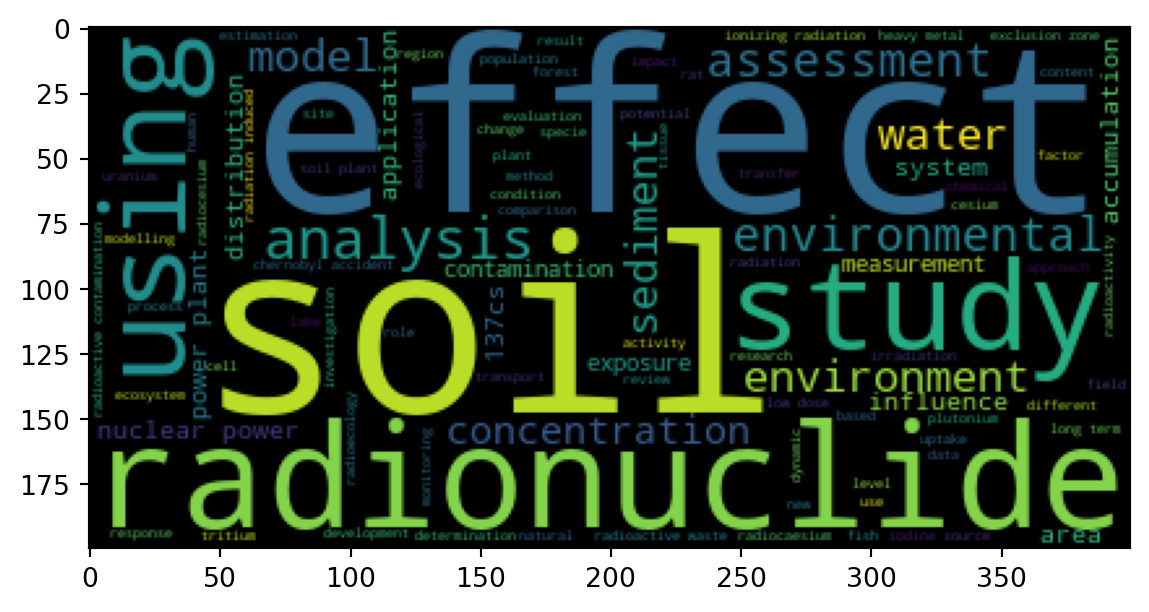

In [11]:
#| label: publis-title-wordcloud
#| fig-cap: Nuage de mots (mots du titre)
#| column: page

all_titles_list = df['Title_cleaned'].to_list()
all_titles_text = " ".join(all_titles_list)
wordcloud = WordCloud(background_color="black",max_words=300).generate(all_titles_text)
plt.imshow(wordcloud)

## Unigrammes (termes uniques les plus utilisés)

In [12]:
#df_title_words_freq = pd.DataFrame(bag_of_word_to_freq(df,'title_cleaned')[:30], columns = ['word' , 'count'])

Le graphique ne montre que les 30 termes les plus fréquents

In [13]:
#| label: title-unigram-barchart
#| column: screen
#| layout-nrow: 1

fig2_1 = px.bar(df_title_unigrams[:30], x = 'word', y = 'count', labels={'count': "Word Frequency"},title="Top 30 des token les plus fréquents (titres)")
fig2_1.update_yaxes(title_text='Fréquence')
fig2_1.update_xaxes(title_text='Token')
fig2_1.show()
df_title_unigrams

word  count
0                       radiation   1489
1                            soil   1352
2                          effect   1175
3                         nuclear   1035
4                           plant   1028
...                           ...    ...
15508                  pedobionts      1
15509                geostandards      1
15510               geoanalytical      1
15511  radioisotopethermoelectric      1
15512                        rtgs      1

[15513 rows x 2 columns]

## Co-occurences (bigrammes)

In [14]:
#| label: title_all-bigrams-barchart
#| column: screen
#| layout-nrow: 1

fig2_2 = px.bar(df_title_bigrams[:50], x = 'bigram_to_string', y = 'count', height=500, labels={'count': "Bigram Frequency"},title="Top 50 des co-occurrences les plus fréquentes (titres)")
fig2_2.update_yaxes(title_text='Fréquence')
fig2_2.update_xaxes(title_text='Co-occurrences')
fig2_2.update_xaxes(tickangle=45)
fig2_2.show()
df_title_bigrams[["bigram","count"]]

bigram  count
0             ('nuclear', 'power')    307
1               ('power', 'plant')    303
2        ('chernobyl', 'accident')    239
3        ('ionizing', 'radiation')    221
4                 ('long', 'term')    196
...                            ...    ...
88066          ('egg', 'northern')      1
88067    ('northern', 'temperate')      1
88068   ('climate', 'radioactive')      1
88069  ('reprocessing', 'nuclear')      1
88070   ('submarine', 'recycling')      1

[88071 rows x 2 columns]

## Co-occurences du terme radioecolog*

In [15]:
df_title_bigrams["with_radioecology"] = df_title_bigrams["bigram_to_string"].apply(lambda x: 'oui' if 'radioecolog' in x else 'non')

In [16]:
#| label: title_radioecology-bigrams-barchart
#| column: screen
#| layout-nrow: 1

fig2_3 = px.bar(df_title_bigrams[df_title_bigrams["with_radioecology"] == 'oui'][:50], x = 'bigram_to_string', y = 'count', height=500, labels={'count': "Bigram Frequency"},title="Top 50 des co-occurences avec le terme radioecolog* (titres)")
fig2_3.update_yaxes(title_text='Fréquence')
fig2_3.update_xaxes(title_text='Co-occurrences "radioecolog*"')
fig2_3.update_xaxes(tickangle=45)
fig2_3.show()
df_title_bigrams[df_title_bigrams["with_radioecology"] == 'oui'][["bigram","count"]]

bigram  count
150          ('radioecological', 'monitoring')     29
223           ('radioecological', 'situation')     22
290               ('radioecological', 'study')     19
474           ('radioecological', 'condition')     13
505          ('radioecological', 'assessment')     13
...                                        ...    ...
86868    ('identification', 'radioecological')      1
86869          ('radioecological', 'approach')      1
87176           ('radioecological', 'support')      1
87981  ('contamination', 'georadioecological')      1
87982        ('georadioecological', 'mapping')      1

[545 rows x 2 columns]

## Visualisation en graphe sur les titres (co-occurrences)

Une visualisation suplémentaire en graphe interactif à partir des **co-occurrences dans les titres des publications** a été produite avec l'instance en ligne du logiciel [VOSwiewer](https://www.vosviewer.com/) et est accessible ici : 

[https://nocodefunctions.com/html/vosviewer/index.html?json=data/public/vosviewer_f021cee7e492b005ff46.json](https://nocodefunctions.com/html/vosviewer/index.html?json=data/public/vosviewer_f021cee7e492b005ff46.json)

![VOSviewer-screenshot-titres](img/VOSviewer-screenshot-titres.png)

In [17]:
# Visu graphe avec pyvis
#net = viz_network(df_title_bigrams)
#net.show('html/title_bigram_network.html')

# Analyse lexicométrique sur les abstracts

## Wordcloud

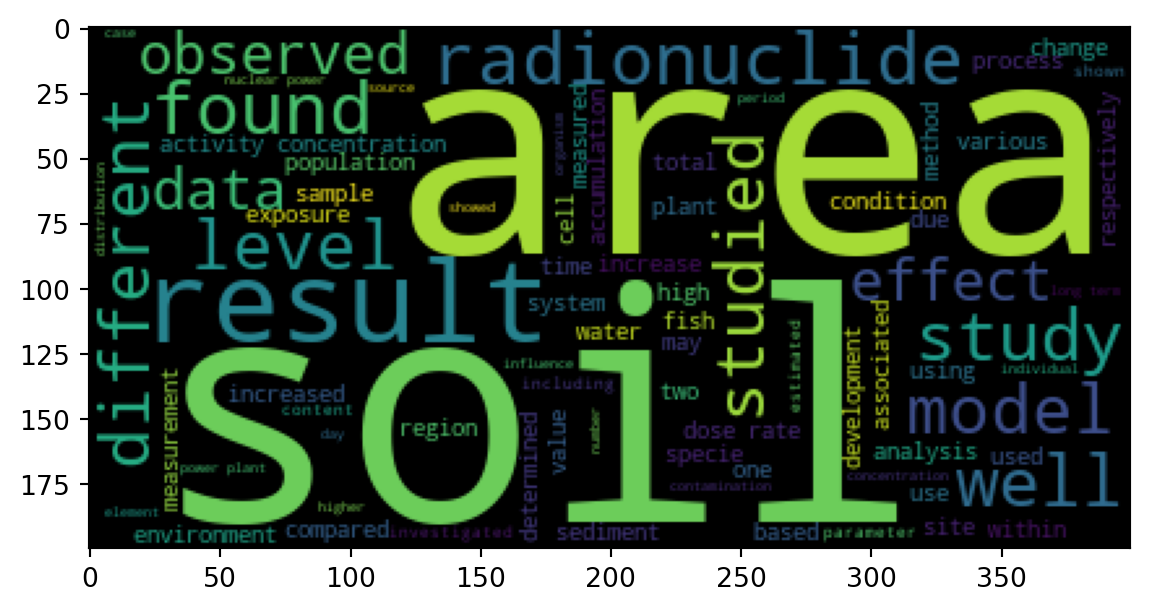

In [18]:
#| label: publis-abstract-wordcloud
#| fig-cap: Nuage de mots (mots des abstracts)
#| column: page

all_abstracts_list = df[df['Abstract_cleaned'].notna()]['Abstract_cleaned'].to_list()
all_abstracts_text = " ".join(all_abstracts_list)
wordcloud = WordCloud(background_color="black",max_words=300).generate(all_abstracts_text)
plt.imshow(wordcloud)

##  Unigrammes

In [19]:
#| label: abstract-unigram-barchart
#| column: screen
#| layout-nrow: 1

fig3_1 = px.bar(df_abstract_unigrams[:30], x = 'word', y = 'count', labels={'count': "Word Frequency"},title="Top 30 des token les plus fréquents (abstracts)")
fig3_1.update_yaxes(title_text='Fréquence')
fig3_1.update_xaxes(title_text='Token')
fig3_1.show()
df_abstract_unigrams

word  count
0           concentration  11193
1                    soil  10451
2               radiation   8368
3                   137cs   7584
4                activity   6967
...                   ...    ...
44982            case90sr      1
44983         itsdaughter      1
44984  thedecommissioning      1
44985            tohumans      1
44986        casescenario      1

[44987 rows x 2 columns]

## Bi-grammes

In [20]:
#| label: abstract_all-bigrams-barchart
#| column: screen
#| layout-nrow: 1

fig3_2 = px.bar(df_abstract_bigrams[:50], x = 'bigram_to_string', y = 'count', height=500, labels={'count': "Bigram Frequency"},title="Top 50 des co-occurrences les plus fréquentes (abstracts)")
fig3_2.update_yaxes(title_text='Fréquence')
fig3_2.update_xaxes(title_text='Co-occurrences')
fig3_2.update_xaxes(tickangle=45)
fig3_2.show()
df_abstract_bigrams[["bigram","count"]]

bigram  count
0       ('activity', 'concentration')   1850
1                    ('dose', 'rate')   1547
2                ('nuclear', 'power')   1083
3                    ('long', 'term')   1032
4                  ('power', 'plant')   1019
...                               ...    ...
717522         ('material', 'stored')      1
717523           ('stored', 'buried')      1
717524       ('buried', 'ecological')      1
717525              ('safety', 'end')      1
717526    ('product', 'reprocessing')      1

[717527 rows x 2 columns]

## Co-occurrences du terme radioecolog*

In [21]:
df_abstract_bigrams["with_radioecology"] = df_abstract_bigrams["bigram_to_string"].apply(lambda x: 'oui' if 'radioecolog' in x else 'non')

In [22]:
#| label: abstract_radioecology-bigrams-barchart
#| column: screen
#| layout-nrow: 1

fig3_3 = px.bar(df_abstract_bigrams[df_abstract_bigrams["with_radioecology"] == 'oui'][:50], x = 'bigram_to_string', y = 'count', height=500, labels={'count': "Bigram Frequency"},title="Top 50 des co-occurences avec le terme radioecolog* (abstracts)")
fig3_3.update_yaxes(title_text='Fréquence')
fig3_3.update_xaxes(title_text='Co-occurrences "radioecolog*"')
fig3_3.update_xaxes(tickangle=45)
fig3_3.show()
df_abstract_bigrams[df_abstract_bigrams["with_radioecology"] == 'oui'][["bigram","count"]]

bigram  count
454        ('radioecological', 'situation')     93
489            ('radioecological', 'study')     88
538            ('radioecological', 'model')     84
548       ('radioecological', 'monitoring')     83
2197        ('radioecological', 'research')     32
...                                     ...    ...
707972           ('fit', 'radioecological')      1
707977          ('case', 'radioecological')      1
708183  ('radioisotope', 'radioecological')      1
708952           ('man', 'radioecological')      1
709524           ('radioecology', 'franco')      1

[1206 rows x 2 columns]

## Visualisation en graphe sur les abstracts (co-occurrences)

In [23]:
# https://nocodefunctions.com/html/vosviewer/index.html?json=data/public/vosviewer_6d4639b3039235dc3f26.json 

Une visualisation suplémentaire en graphe interactif à partir des **co-occurrences dans les abstracts des publicatiosn** a été produite avec l'instance en ligne du logiciel [VOSwiewer](https://www.vosviewer.com/) et est accessible ici : 

[https://nocodefunctions.com/html/vosviewer/index.html?json=data/public/vosviewer_eb7b4a353b54d705cb3a.json](https://nocodefunctions.com/html/vosviewer/index.html?json=data/public/vosviewer_eb7b4a353b54d705cb3a.json)

![VOSviewer-screenshot-abstracts](img/VOSviewer-screenshot-abstracts.png)

# Télécharger les données

Trois types de fichiers ont été produits :
- un fichier contenant les métadonnées des 11 862 publications
- des fichiers contenant la liste des **termes uniques** et leurs fréquences
  - dans les mots du titre
  - dans les mots des abstracts
- un fichier contenant la liste de toutes les **paires de co-occurrences** avec leurs fréquences d'apparition
  - dans les mots du titre
  - dans les mots des abstracts

Chaque fichier est disponible en formats .csv et .xlsx.

In [24]:
display(FileLinks("data/2_results/"))

data/2_results/
  abstracts_network.gexf
  Abstract_bigrams.csv
  Abstract_bigrams.xlsx
  Abstract_unigrams.csv
  Abstract_unigrams.xlsx
  nlp_corpus.csv
  nlp_corpus.xlsx
  title_bigrams.csv
  title_bigrams.xlsx
  Title_unigrams.csv
  Title_unigrams.xlsx

*NB : le 1er fichier abstracts_network.gexf contient les données du réseau formé par les co-occurrences des abstracts structurées selon le format attendu par les outils de visualisation de graphes. Il est ainsi directement importable dans des logiciels tels que [Gephi](https://gephi.org/)*

# Autres outils de text mining en ligne

Voyant Tools : [https://voyant-tools.org/](https://voyant-tools.org/)

Nocode functions : [https://nocodefunctions.com/index.html](https://nocodefunctions.com/index.html)

# Code source

[https://github.com/azur-scd/appui_recherche_corpus_radioecology](https://github.com/azur-scd/appui_recherche_corpus_radioecology)